In [1]:
using CSV
using DataFrames
using Hungarian
using InferOpt
using Flux
using StatsBase
using MLJ
using ProgressMeter
using Distances
using Random

In [2]:
using JuMP
using MathOptInterface
using Gurobi
using Graphs
using Plots
using JLD2
using FileIO

In [3]:
include("optimization_Util.jl")

display_solution (generic function with 1 method)

### Training and evaluation of the pipeline using a generic regularization layer 

In [4]:
ENV["COLUMNS"] = 100
ENV["LINES"] = 100
Random.seed!(67);

In [5]:
file = File(format"JLD2", "Data/train_data.jld2")
train_data = JLD2.load(file)

Dict{String, Any} with 4 entries:
  "Y"   => [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0;…
  "X"   => Array{Float32, 3}[[0.0 0.0 … 0.0 0.0; 0.0303127 0.0325272 … 0.0179837 0.0136011; 0.02519…
  "X_A" => DataFrame[67×2 DataFrame…
  "X_C" => DataFrame[201×2 DataFrame…

In [6]:
file = File(format"JLD2", "Data/test_data.jld2")
test_data = JLD2.load(file)

Dict{String, Any} with 4 entries:
  "Y"   => [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0;…
  "X"   => Array{Float32, 3}[[1.0 0.0 … 0.0 0.0; 0.0174359 0.0132141 … 0.00802322 0.0326288; 0.0329…
  "X_A" => DataFrame[54×2 DataFrame…
  "X_C" => DataFrame[177×2 DataFrame…

In [7]:
X_train, X_A_train, X_C_train, Y_train = train_data["X"], train_data["X_A"], train_data["X_C"], train_data["Y"];

In [8]:
X_test, X_A_test, X_C_test, Y_test = test_data["X"], test_data["X_A"], test_data["X_C"], test_data["Y"];

In [9]:
"""
optimizer(cost_matrix)

Wrapper function for the hungarian assignment algorithm.
"""
function optimizer(cost_matrix)
    vector = hungarian(-cost_matrix)[1]
    n, m = size(cost_matrix)

    # Create a matrix of size n×n filled with 0's
    matrix = zeros(Int, n, m)

    # Set the value to 1 at the specified points in the vector
    for i in 1:length(vector)
        matrix[i, vector[i]] = 1
    end
    return matrix
end

optimizer

Generic Regularization layer from InferOpt using the half_square_norm with FenchelYoung Loss

In [10]:
optimizer_layer = RegularizedGeneric(
    optimizer;
    omega=y -> half_square_norm(y),
    omega_grad=y -> y
    )
loss = FenchelYoungLoss(optimizer_layer);

Linear Model for each entry in the Matrix
with dimension reduction to reduce M:N:4 Matrix to M:N Matrix

In [11]:
og_encoder = Chain(
  Dense(4, 1),
  z -> dropdims(z; dims=1),
)

Chain(
  Dense(4 => 1),                        # 5 parameters
  var"#32#33"(),
) 

Trainings run of the Pipeline using Adam optimizer with early stop and best model recovery

In [12]:
# Create a copy of the original encoder
encoder = deepcopy(og_encoder)

# Initialize the optimizer
opt_state = Flux.setup(Adam(), encoder)

# Initialize the losses array
losses = Float64[]
best_loss = Inf
best_model = deepcopy(encoder)

# Define the early stopping criterion
es = Flux.early_stopping(() -> best_loss, 5)

@showprogress "Training epoch:" for epoch in 1:200
    l = 0.0
    # Iterate through each data point
    for (x, y) in zip(X_train, Y_train)
        
        # Calculate gradients using the current data point
        val, grads = Flux.withgradient(encoder) do m
            # Any code inside here is differentiated.
            # Evaluation of the model and loss must be inside!
            result = m(x)
            loss(result, y)
        end
        l += val 
        # Update the model parameters using the calculated gradients
        Flux.update!(opt_state, encoder, grads[1])
    end

    # Calculate average loss for this epoch
    average_loss = l / length(X_train)
    # Append the average loss to the losses array
    push!(losses, average_loss)
    # Check for improvement 
    if average_loss < best_loss && average_loss > 0
        best_loss = average_loss
        best_model = deepcopy(encoder)
    else
        es() && break
    end
end
encoder = best_model  # set encoder to the best model

Training epoch:   1%|█                                   |  ETA: 1:22:49

Training epoch:   2%|█                                   |  ETA: 1:06:26

Training epoch:   2%|█                                   |  ETA: 0:57:47

Training epoch:   2%|█                                   |  ETA: 0:52:47

Training epoch:   3%|██                                  |  ETA: 0:49:21

Training epoch:   4%|██                                  |  ETA: 0:46:26

Training epoch:   4%|██                                  |  ETA: 0:42:57

Training epoch:   4%|██                                  |  ETA: 0:40:15

Training epoch:   6%|██                                  |  ETA: 0:36:24

Training epoch:   6%|███                                 |  ETA: 0:34:55

Training epoch:   6%|███                                 |  ETA: 0:33:50

Training epoch:   7%|███                                 |  ETA: 0:32:42

Training epoch: 100%|████████████████████████████████████| Time: 0:02:34


Chain(
  Dense(4 => 1),                        # 5 parameters
  var"#32#33"(),
) 

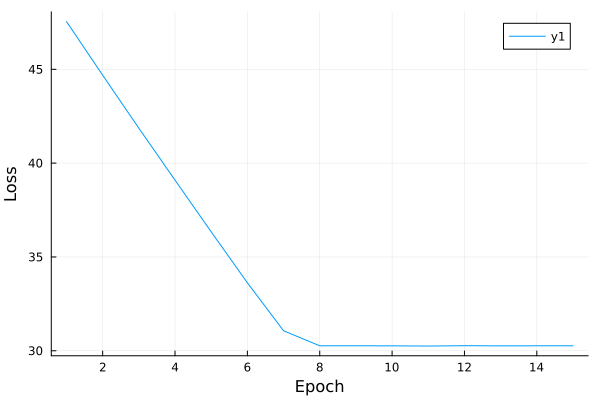

In [13]:
plot(losses; xlabel="Epoch", ylabel="Loss")

In [14]:
Y_test_pred = [optimizer(encoder(x)) for x in X_test];

Evaluations of the resulting pipeline using TravelingSalesPerson with pickup and delivery

In [15]:
pred_deliveries, pred_constraints = create_deliveries(X_A_test, X_C_test, Y_test_pred)
true_deliveries, true_constraints = create_deliveries(X_A_test, X_C_test, Y_test)

(Any[Any[Delivery(0.285346664252601, 0.6273783228378499), Delivery(0.24729524152972113, 0.6628829842550245), Delivery(0.3783120422506709, 0.048379579810059865), Delivery(0.47991851433751576, 0.3707969674749293), Delivery(0.8264013413387067, 0.4703621739147121), Delivery(0.8239548385343233, 0.606538926136958), Delivery(0.1350309617043981, 0.3708253000664519), Delivery(0.132045408695281, 0.43123728701746944), Delivery(0.43696027617590094, 0.48756806489193616), Delivery(0.5256088107148651, 0.45820021948378514)  …  Delivery(0.39307066589540063, 0.4521628001019801), Delivery(0.2599478427455764, 0.34918721588169577), Delivery(0.19145244001483747, 0.4720641267535328), Delivery(0.12007041323853788, 0.3480334978059114), Delivery(0.2947361659722497, 0.32271153723750273), Delivery(0.518799375267699, 0.3719299120233189), Delivery(0.20720045402617457, 0.33598569900260533), Delivery(0.14732147941555362, 0.40038345148013094), Delivery(0.3374655945205997, 0.12195601148557526), Delivery(0.3748302976539

In [16]:
pred_solution = []
@showprogress 30 "progress ..." for (delivery, constraint) in zip(pred_deliveries, pred_constraints)
   push!(pred_solution, solve_tsp(delivery, constraint, Gurobi.Optimizer));
end

progress ...   3%|██                                     |  ETA: 0:26:27

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   6%|███                                    |  ETA: 0:25:13

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   8%|████                                   |  ETA: 0:47:22

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  10%|████                                   |  ETA: 0:44:50

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  11%|█████                                  |  ETA: 0:46:23

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  13%|██████                                 |  ETA: 1:34:15

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  15%|██████                                 |  ETA: 1:23:06

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  18%|████████                               |  ETA: 1:10:46

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  20%|████████                               |  ETA: 1:05:38

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  30%|████████████                           |  ETA: 0:56:01

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  35%|██████████████                         |  ETA: 0:47:11

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  37%|███████████████                        |  ETA: 0:44:56

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  38%|███████████████                        |  ETA: 0:45:25

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  40%|████████████████                       |  ETA: 0:43:05

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  50%|████████████████████                   |  ETA: 0:35:33

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  51%|████████████████████                   |  ETA: 0:36:49

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  52%|█████████████████████                  |  ETA: 0:36:15

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  54%|██████████████████████                 |  ETA: 0:34:03

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  59%|████████████████████████               |  ETA: 0:29:54

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  60%|████████████████████████               |  ETA: 0:29:01

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  61%|████████████████████████               |  ETA: 0:28:27

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  62%|█████████████████████████              |  ETA: 0:27:53

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  67%|███████████████████████████            |  ETA: 0:24:51

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  68%|███████████████████████████            |  ETA: 0:24:12

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  69%|███████████████████████████            |  ETA: 0:23:25

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  71%|████████████████████████████           |  ETA: 0:21:38

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  72%|█████████████████████████████          |  ETA: 0:21:01

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  75%|██████████████████████████████         |  ETA: 0:18:24

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  76%|██████████████████████████████         |  ETA: 0:17:40

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  77%|███████████████████████████████        |  ETA: 0:17:11

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  79%|███████████████████████████████        |  ETA: 0:15:31

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  80%|████████████████████████████████       |  ETA: 0:14:48

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  82%|████████████████████████████████       |  ETA: 0:13:17

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  84%|█████████████████████████████████      |  ETA: 0:11:39

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  85%|██████████████████████████████████     |  ETA: 0:10:54

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  86%|██████████████████████████████████     |  ETA: 0:10:32

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  89%|███████████████████████████████████    |  ETA: 0:08:09

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  90%|████████████████████████████████████   |  ETA: 0:07:25

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  91%|████████████████████████████████████   |  ETA: 0:06:41

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  93%|█████████████████████████████████████  |  ETA: 0:05:10

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  94%|█████████████████████████████████████  |  ETA: 0:04:27

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  96%|██████████████████████████████████████ |  ETA: 0:02:56

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  98%|███████████████████████████████████████|  ETA: 0:01:27

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ... 100%|███████████████████████████████████████| Time: 1:11:41


Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


In [17]:
file = File(format"JLD2", "Data/regulized_output.jld2")
  
# Save data into the file
save(file, "delivery", pred_deliveries, "constraint", pred_constraints, "solutions", pred_solution, "trainings_losses", losses)